# Introduction

This notebook demonstrates an example of displaying an UCoMP and an AIA image in the same map using SunPy.



#### Credits

Thanks to Yingjie Zhu for the initial notebook for this display and pointing out problems in our initial UCoMP level 1 headers.

#### Requirements

- The astropy, sunpy, aiapy, and matplotlib libraries are required to run this notebook.
- A UCoMP L2 fits file saved locally on disk. Once the MLSO data API is released, we will update this notebook to download the needed files. UCoMP images can be obtained from the [UCoMP calendar of the MLSO website](https://mlso.hao.ucar.edu/mlso_data_calendar.php?calinst=ucomp). For example a 1074 L2 file 2022-04-07 taken at 18:07:54 UTC.
  - `20220407.180754.ucomp.1074.l2.fts`
  
- Network access to so FIDO can download the AIA image taken close in time to the UCoMP image.

In [99]:
from astropy.io import fits
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch,PowerStretch
from astropy.coordinates import SkyCoord

from sunpy.map import Map

import matplotlib.pyplot as plt


from sunpy.coordinates import SphericalScreen

import matplotlib.pyplot as plt


from pathlib import Path
import copy
from astropy.time import Time
from sunpy.net import Fido, attrs as a
from datetime import timedelta

### Define the UCoMP file you plan to compare with AIA

The ucomp_data_file should be in our path or in the same directory as the notebook.

In [100]:
ucomp_data_file_path = Path("20220407.180754.ucomp.1074.l2.fts")

ucomp_filename = ucomp_data_file_path.name
# Use the file name to create an astropy stamp.
ucomp_time = Time(f"{ucomp_filename[:4]}-{ucomp_filename[4:6]}-{ucomp_filename[6:8]}T{ucomp_filename[9:11]}:{ucomp_filename[11:13]}:{ucomp_filename[13:15]}")


In [101]:
with fits.open(ucomp_data_file_path) as ucomp_hdul:
    ucomp_hdul.info()
    ucomp_enhanced_intensity_1074 = ucomp_hdul[2].data
    ucomp_mask = ucomp_hdul[6].data 
    ucomp_primary_header = ucomp_hdul[0].header
    ucomp_enhanced_intensity_header = ucomp_hdul[2].header

Filename: 20220407.180754.ucomp.1074.l2.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     200   ()      
  1  Center wavelength intensity    1 ImageHDU        19   (1280, 1024)   float32   
  2  Enhanced intensity    1 ImageHDU        19   (1280, 1024)   float32   
  3  Peak intensity    1 ImageHDU        18   (1280, 1024)   float32   
  4  LOS velocity    1 ImageHDU        21   (1280, 1024)   float32   
  5  Line width (FWHM)    1 ImageHDU        18   (1280, 1024)   float32   
  6  Noise mask    1 ImageHDU        18   (1280, 1024)   float32   
  7  Weighted average I    1 ImageHDU        18   (1280, 1024)   float32   
  8  Weighted average Q    1 ImageHDU        18   (1280, 1024)   float32   
  9  Weighted average U    1 ImageHDU        18   (1280, 1024)   float32   
 10  Weighted average L    1 ImageHDU        18   (1280, 1024)   float32   
 11  Azimuth       1 ImageHDU        18   (1280, 1024)   float32   
 12  Radial azimuth    1 

Astropy's FITS reader doesn't seem to want to inherit from the primary header when reading the extension header, even though `INHERIT` is set to 'T'. So we copy the UCoMP primary header and change the `NAXIS` keywords to match the extension data.

In [102]:
ucomp_primary_header_naxis = copy.deepcopy(ucomp_primary_header)
ucomp_primary_header_naxis["NAXIS1"] = ucomp_enhanced_intensity_header["NAXIS1"]
ucomp_primary_header_naxis["NAXIS2"] = ucomp_enhanced_intensity_header["NAXIS2"]
del ucomp_primary_header_naxis["NAXIS"]

In [103]:
#Create a sunpy map for the ucomp data using the composite Primary and enhanced intensity header, 
#and enhanced intensity data * the noise mask.

ucomp_map = Map(ucomp_enhanced_intensity_1074*ucomp_mask, ucomp_primary_header)

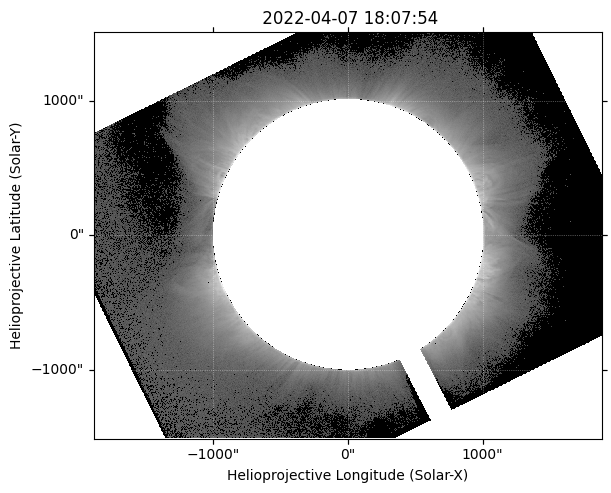

In [104]:
fig = plt.figure(figsize=(6, 6), constrained_layout=True)

norm_ucomp_1074 = ImageNormalize(ucomp_map.data, stretch=PowerStretch(.2), vmin=0)
ax = fig.add_subplot(projection=ucomp_map)
_ = ucomp_map.plot(axes=ax, norm=norm_ucomp_1074)

Download an AIA 193 image associated with UCoMP file file time stamp:

In [105]:
result= Fido.search(a.Time(ucomp_time-timedelta(minutes=1), ucomp_time+timedelta(minutes=1)),
            a.Instrument("aia"), a.Wavelength(193*u.angstrom) )

aia_map = Map(Fido.fetch(result[0, 0]))

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

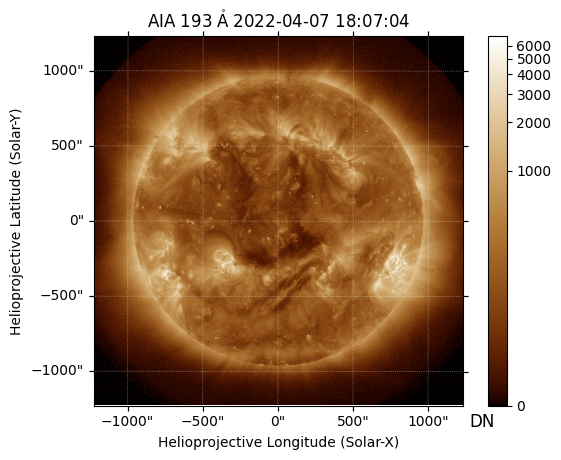

In [106]:
aia_map.peek(vmin=0)

By default Sunpy ignores the off-limb data when reprojecting Maps so we need to added a SphericalScreen to keep the off-limb AIA data.  This technique is borrowed from the Sunpy example code that overlays AIA and LASCO C2; where we substitute the UCoMP Maps for the C2 Maps.

[Overlay an AIA image on a LASCO C2 coronagraph](https://docs.sunpy.org/en/stable/generated/gallery/plotting/lasco_overlay.html)

In [107]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=ucomp_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=ucomp_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)
projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)
# We use `~sunpy.coordinates.SphericalScreen` to ensure that the off limb AIA pixels
# are reprojected. Otherwise it will only be the on disk pixels that are reprojected.
with SphericalScreen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

Projecting AIA to UCoMP data.

Text(0.5, 1.0, 'AIA and UCoMP 1074 Intensity Overlay')

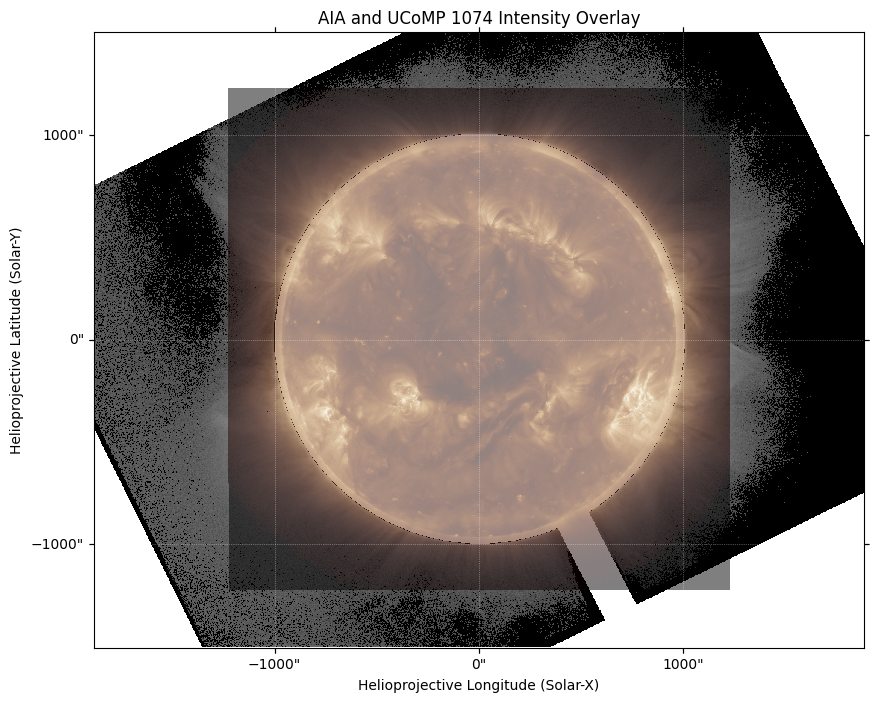

In [108]:
fig = plt.figure()
ax = fig.add_subplot(projection=ucomp_map)
fig.set_figheight(8)
fig.set_figwidth(10)
norm_aia = ImageNormalize(aia_map_reproject.data, stretch=AsinhStretch(), vmin=0)
norm_ucomp_1074 = ImageNormalize(ucomp_map.data, stretch=PowerStretch(.2), vmin=0)
ucomp_map.plot(axes=ax,norm=norm_ucomp_1074)
aia_reprojected.plot(axes=ax, autoalign=True,alpha=.5,norm=norm_aia)
ax.set_title("AIA and UCoMP 1074 Intensity Overlay")
